# 1 Introduzione

Questa è una guida, ad uso personale, che ho scritto per allenarmi nell'utilizzo di alcune
funzionalità di Python.  Il dataset che verrà utilizzato riguarda i punteggi
 dei giocatori di scacchi registrati al FIDE dal 2000 al 2021, disponibili su https://ratings.fide.com/download.phtml.

Ho scelto questo dataset un po' per curiosità e un po' perché permette di applicare delle statistiche interessanti.
Si tratta infatti di un dataset abbastanza grande da costringerci ad ottimizzare le operazioni, ma
 non troppo da non farci perdere troppo tempo.

Il file *load_data.py* contiene le istruzioni necessarie per scaricare il dataset direttamente dal sito della FIDE.
Già qui abbiamo un problema, perché si tratta di una serie di file .txt formattati in modo diverso
a seconda della data di redazione.

Comunque alla fine otteniamo due dataset, uno contenente le statistiche mese per mese (inizialmente
solo alcuni mesi sono considerati, più recentemente abbiamo statistiche per ogni mese) e uno contenente
la lista di tutti i giocatori iscritti al FIDE. I giocatori sono identificati dal numero ID, presente
in entrambi i dataset.

Qui inizia questo notebook, che ripeto, ha sopratutto lo scopo di servire da cheatsheet.
Se invece siete interessati unicamente alle statistiche sugli scacchi, presentate in modo più organico,
consultate il file *statistics.ipynb*

Iniziamo col ** caricare il dataset **

In [1]:
# thanks to  https://realpython.com/pandas-groupby/
import pandas as pd
import load_data
import seaborn as sns
import matplotlib.pyplot as plt
rank = load_data.load_ranking()
players = load_data.load_players()
print(rank.head())
print(players.head())

        id                  name     elo title       date
0  1701991         Aaberg, Anton  2300.0   NaN 2001-01-01
1  1401815        Aagaard, Jacob  2374.0    im 2001-01-01
2  1500503  Aarland, Stein Arild  2275.0   NaN 2001-01-01
3  5000092         Aaron, Manuel  2315.0    im 2001-01-01
4  5004373    Aarthie, Ramaswamy  2250.0   wim 2001-01-01
         id                       name country  birth_year sex
0  33200025                        NaN     SKN           0   M
1  10688862       A Abdel Maabod, Hoda     EGY        2009   F
2  10224084  A B M Hasibuzzaman, Tapan     BAN        1977   M
3  10245154      A B M Jobair, Hossain     BAN        1998   M
4  10243054  A B M Mustakim, Chowdhury     BAN        2013   M


Vediamo quali sono le nazioni che hanno più iscritti

Text(0.5, 1.0, 'FIDE chess players by country')

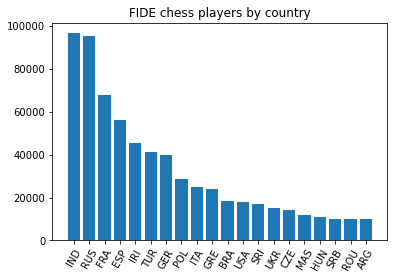

In [28]:
country_numb = players["country"].value_counts()
top_20 = country_numb.head(20)
plt.bar(top_20.index, top_20)
plt.xticks(rotation=60)
plt.title("FIDE chess players by country")#vertical x labels for better reading

Proviamo una distinzione per sesso:

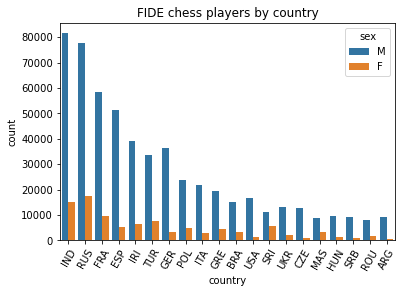

In [32]:
#usando order decidiamo quali classi plottare e in che ordine

sns.countplot(x="country", hue="sex", data=players, order=top_20.index)
plt.title("FIDE chess players by country")
plt.xticks(rotation=60); #<-- il carattere ; sopprime l'output testo in jupyter (ultima istruzione)

Questi dati sembrano un po' strani. Proviamo a restringerci unicamenti ai giocatori con ELO>2200.
Per prima cosa dobbiamo fondere il dataset degli ELO con quello dei giocatori.

In [36]:
del(rank["name"]) #we already have the name column in player dataset
joined = pd.merge(players, rank, how='inner', on='id')
joined.sample(5) #invece di stampare i primi 5, ne stampo 5 a caso

,id,name,country,birth_year,sex,elo,title,date
2279988,1101617,"Szalajdewicz, Janusz",POL,1954,M,2290.0,NaN,2003-07-01
1771865,904627,"Petrovic, Slobodan S",SRB,1957,M,2290.0,fm,2015-02-01
1338236,4125134,"Loginov, Anton",RUS,1963,M,2226.0,NaN,2018-03-01
1017148,724270,"Juhasz, Armin",HUN,1998,M,2373.0,im,2020-03-01
342322,5100119,"Campos Ruiz, Alberto",MEX,1953,M,2250.0,fm,2012-09-01


Bene, ora pero non possiamo applicare la stessa funzione di prima, perché ogni giocatore appare più
volte, e non tutti lo stesso numero di volte. Conteremo quindi ogni giocatore una volta sola, e
terremo come il valore di ELO il suo massimo storico

In [68]:
by_player = joined.groupby(by="id")
one_time = by_player.agg(elo=('elo', 'max'), country=('country', 'first'), sex=('sex', 'first'))
one_time.head()

,elo,country,sex
id,,,
100013,2549.0,ARG,M
100021,2503.0,ARG,M
100030,2485.0,ARG,M
100048,2454.0,ARG,M
100072,2518.0,ARG,M


Come sono distribuiti gli ELO?

Index(['elo', 'country', 'sex'], dtype='object')


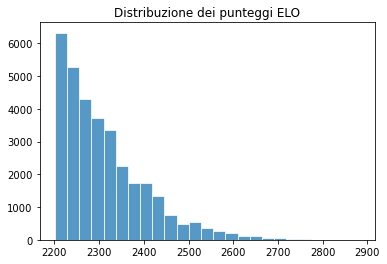

In [91]:
print(one_time.columns)
plt.hist(x=one_time["elo"], bins=25, ec='white', alpha=0.75);
plt.title("Distribuzione dei punteggi ELO");

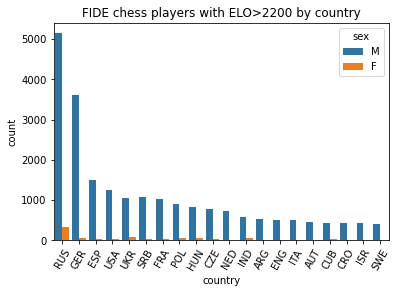

In [80]:
min_elo = 2200
high_elo = one_time[one_time.elo>min_elo]
country_numb = high_elo["country"].value_counts()
top_20 = country_numb.head(20)
sns.countplot(x="country", hue="sex", data=high_elo, order=top_20.index)
plt.title(f"FIDE chess players with ELO>{min_elo} by country")
plt.xticks(rotation=60);

Proviamo ora a studiare i dati annuali. Dato che abbiamo dei dati mensili, proviamo a raggrupparli per anno.
Prendiamo la media dei punteggi ELO

In [131]:
by_year = joined.groupby(by=[joined["date"].dt.year, joined["id"]])
year_data = by_year.agg(name=('name', 'first'), elo=('elo', 'mean'), country=('country', 'first'), sex=('sex', 'first'), title=('title', 'first'), birth_year=('birth_year', 'first'))
year_data = year_data.reset_index(level=['id', 'date'])
year_data.rename(columns={'date': 'year'}, inplace=True)
year_data["age"] = year_data["year"] - year_data["birth_year"]
year_data.head()

,year,id,name,elo,country,sex,title,birth_year,age
0,2001,100013,"Campora, Daniel H.",2518.333333,ARG,M,gm,1957,44
1,2001,100021,"Quinteros, Miguel A.",2503.000000,ARG,M,gm,1947,54
2,2001,100030,"Montenegro, Noe",2485.000000,ARG,M,gm,1996,5
3,2001,100048,"Iapichello, Javier",2454.000000,ARG,M,gm,1990,11
4,2001,100072,"Adla, Diego",2501.666667,ARG,M,im,1968,33


In [132]:
for year, frame in year_data.groupby(by="year"):
    print(f"Top 5 female players in {year}")
    print(frame[frame.sex=="F"].sort_values(by="elo", ascending=False).head(5))
    print(f"Top 5 male players in {year}")
    print(frame[frame.sex=="M"].sort_values(by="elo", ascending=False).head(5))
    print(40*"_")

Top 5 female players in 2001
       year        id               name          elo country sex title  \
1872   2001    700070      Polgar, Judit  2682.666667     HUN   F   wgm   
17250  2001  14200074  Ibragimova, Iroda  2649.000000     UZB   F    gm   
1873   2001    700088      Polgar, Susan  2565.000000     HUN   F   wgm   
15375  2001   8600147           Xie, Jun  2554.333333     CHN   F   wgm   
10084  2001   4129725  Galliamova, Alisa  2549.333333     RUS   F   wgm   

       birth_year  age  
1872         1976   25  
17250        1991   10  
1873         1969   32  
15375        1970   31  
10084        1972   29  
Top 5 male players in 2001
       year       id                   name          elo country sex title  \
8919   2001  4100018        Kasparov, Garry  2841.666667     RUS   M    gm   
8967   2001  4101588      Kramnik, Vladimir  2794.333333     RUS   M    gm   
14475  2001  5000017     Anand, Viswanathan  2784.666667     IND   M    gm   
9460   2001  4116992  Morozevic

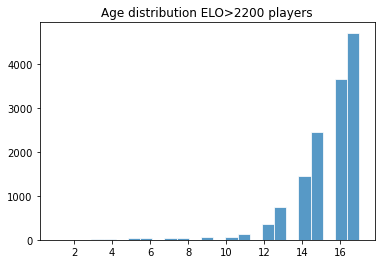

In [150]:
# Togliamo i dati in cui manca la data di nascita
year_data = year_data[year_data["birth_year"]!=0]

plt.hist(x=year_data["age"], bins=25, ec='white', alpha=0.75);
plt.title("Age distribution ELO>2200 players");

In [155]:
year_data[year_data["age"]<20].age.value_counts()

19    6043
18    5587
17    4725
16    3660
15    2453
14    1446
13     748
12     353
11     127
10      75
9       56
8       40
7       39
6       37
5       31
4       20
3       15
2        6
1        3
Name: age, dtype: int64

In [156]:
year_data[year_data["age"]<4]

,year,id,name,elo,country,sex,title,birth_year,age
240,2001,103896,"Foti, Angel",2260.000000,ARG,M,NaN,2000,1
588,2001,301680,"Kratochvilova, Jana",2260.000000,CZE,F,NaN,1999,2
1898,2001,700401,"Shan, He Jia Rita",2286.000000,HUN,F,gm,1998,3
2114,2001,703737,"Farkas, Akos",2208.000000,HUN,M,NaN,1999,2
2298,2001,711691,"Szajbely, Zsigmond",2210.000000,HUN,M,NaN,1998,3
2304,2001,712566,"Molnar Saska, Zoltan",2207.000000,HUN,M,NaN,1999,2
6793,2001,2200716,"Del Moral Escudero, Abel",2305.000000,ESP,M,NaN,2000,1
8090,2001,2900840,"Shivacheva, Donika",2305.000000,BUL,F,NaN,1999,2
8100,2001,2900955,"Vasova, Maria",2270.000000,DEN,F,NaN,1998,3
8243,2001,2904055,"Petkov, Boris",2210.000000,BUL,M,NaN,1999,2
